<a href="https://colab.research.google.com/github/TheoDeann/Graphical_Model_Project/blob/main/GM_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install --upgrade torch
# !pip install torch-geometric
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu117.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu117.html
# !pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu117.html
# !pip install --upgrade tqdm
import torch
print(torch.__version__)

2.0.0+cu117


In [ ]:
# !pip install --upgrade torch-geometric

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv, GINConv,global_mean_pool, global_add_pool
from torch_geometric.data import DataLoader
from torch_geometric.utils import train_test_split_edges, add_self_loops, degree
import torch_geometric.transforms as T
from torch_geometric.transforms import NormalizeFeatures,OneHotDegree
from torch.utils.data import random_split
from torch_geometric.data import InMemoryDataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.manifold import TSNE

# CiteSeer Dataset - Node Classification

**GAT**

In [ ]:
# Download and load the dataset
dataset = Planetoid(root='data/CiteSeer', name='CiteSeer', transform=NormalizeFeatures())
data = dataset[0]
print(data)

Processing...


Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


Done!


In [ ]:
data.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

<BarContainer object of 32 artists>

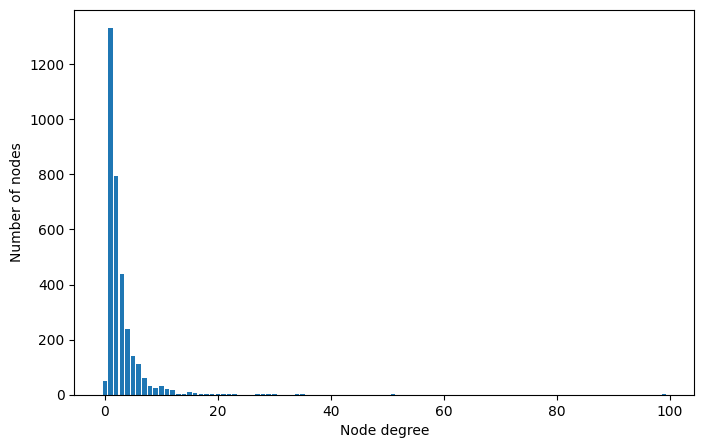

In [ ]:
# Get the list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values())

In [ ]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Create the train/validation/test split
data = dataset[0]
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[:int(data.num_nodes * 0.8)] = 1
data.val_mask[int(data.num_nodes * 0.8):int(data.num_nodes * 0.9)] = 1
data.test_mask[int(data.num_nodes * 0.9):] = 1

# Convert the data to PyTorch tensors and move to the device
x = data.x.to(device)
y = data.y.to(device)
train_mask = data.train_mask.to(device)
val_mask = data.val_mask.to(device)
test_mask = data.test_mask.to(device)
edge_index = data.edge_index.to(device)

In [ ]:
data

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

In [ ]:
# Define GAT_LINEAR model
class GAT_LINEAR(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 heads):
        super().__init__()

        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.convs = torch.nn.ModuleList()
        self.lin1 = torch.nn.Linear(in_channels, heads * hidden_channels)
        self.lin2 = torch.nn.Linear(heads * hidden_channels, heads * hidden_channels)
        for i in range(num_layers - 2):
            self.convs.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads))
        self.convn = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu((self.conv1(x, edge_index)) + self.lin1(x))
        for conv in self.convs:
            x = F.dropout(x, p=0.6, training=self.training)
            x = F.elu(conv(x, edge_index) + self.lin2(x))
        x = self.convn(x, edge_index)
        return x,F.log_softmax(x, dim=1)

In [ ]:
# Define GAT model
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 heads):
        super().__init__()

        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 2):
            self.convs.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads))
        self.convn = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu((self.conv1(x, edge_index)))
        for conv in self.convs:
            x = F.dropout(x, p=0.6, training=self.training)
            x = F.elu(conv(x, edge_index))
        x = self.convn(x, edge_index)
        return x,F.log_softmax(x, dim=1)

In [ ]:
# Train the model
def train(model):
    model.train()
    train_acc_list = []
    val_acc_list = []
    for epoch in range(200):
        optimizer.zero_grad()
        _,out = model(x, edge_index)
        loss = criterion(out[train_mask], y[train_mask])
        train_pred = out.argmax(dim=1)
        train_acc = float(train_pred[train_mask].eq(y[train_mask]).sum()) / int(train_mask.sum())
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            # Evaluate the model on the validation set
            with torch.no_grad():
                _,val_out = model(x, edge_index)
                val_loss = criterion(val_out[val_mask], y[val_mask])
                val_pred = val_out.argmax(dim=1)
                val_acc = float(val_pred[val_mask].eq(y[val_mask]).sum()) / int(val_mask.sum())
                val_acc_list.append(val_acc)
                train_acc_list.append(train_acc)
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
        
    return train_acc_list, val_acc_list

# Evaluate the model
def evaluate(model):
    model.eval()
    with torch.no_grad():
        _,out = model(x, edge_index)
        pred = out.argmax(dim=1)
        test_acc = float(pred[test_mask].eq(y[test_mask]).sum()) / int(test_mask.sum())
        print(f'Test Accuracy: {test_acc:.4f}')

def acc_plot(train_acc_list,val_acc_list):
  # Plot the train and validation accuracy curves
  plt.plot(train_acc_list, label='Train Acc')
  plt.plot(val_acc_list, label='Val Acc')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
# Define model parameters
in_channels = dataset.num_features
hidden_channels = 8
out_channels = dataset.num_classes
num_heads = 2

# Instantiate model and optimizer
gat_linear = GAT_LINEAR(in_channels, hidden_channels, out_channels, 3, num_heads).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(gat_linear.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

Epoch: 000, Loss: 1.7910, Val Loss: 1.7663, Train Acc: 0.1443, Val Acc: 0.2012
Epoch: 010, Loss: 1.4851, Val Loss: 1.4725, Train Acc: 0.5675, Val Acc: 0.5556
Epoch: 020, Loss: 1.0405, Val Loss: 1.0905, Train Acc: 0.7016, Val Acc: 0.6637
Epoch: 030, Loss: 0.8195, Val Loss: 0.9350, Train Acc: 0.7471, Val Acc: 0.6847
Epoch: 040, Loss: 0.7199, Val Loss: 0.8775, Train Acc: 0.7648, Val Acc: 0.7177
Epoch: 050, Loss: 0.6701, Val Loss: 0.8308, Train Acc: 0.7783, Val Acc: 0.7297
Epoch: 060, Loss: 0.6334, Val Loss: 0.8510, Train Acc: 0.7884, Val Acc: 0.7027
Epoch: 070, Loss: 0.5966, Val Loss: 0.8171, Train Acc: 0.7982, Val Acc: 0.7207
Epoch: 080, Loss: 0.5742, Val Loss: 0.8722, Train Acc: 0.8129, Val Acc: 0.7177
Epoch: 090, Loss: 0.5649, Val Loss: 0.8408, Train Acc: 0.8057, Val Acc: 0.7327
Epoch: 100, Loss: 0.5315, Val Loss: 0.8799, Train Acc: 0.8215, Val Acc: 0.7147
Epoch: 110, Loss: 0.5160, Val Loss: 0.8703, Train Acc: 0.8286, Val Acc: 0.7508
Epoch: 120, Loss: 0.5138, Val Loss: 0.8894, Train Ac

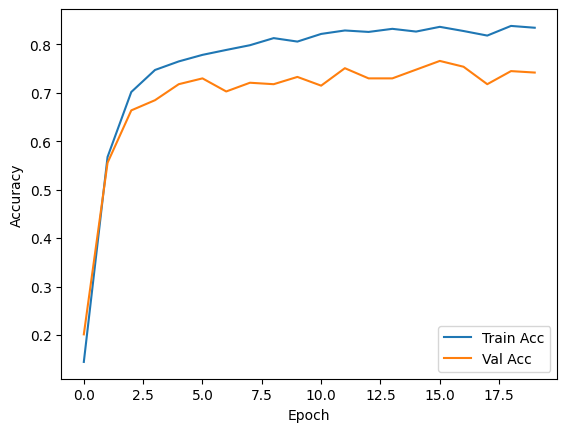

In [ ]:
train_acc_list,val_acc_list = train(gat_linear)
evaluate(gat_linear)
acc_plot(train_acc_list,val_acc_list)

In [ ]:
# Instantiate model and optimizer
gat = GAT(in_channels, hidden_channels, out_channels, 3, num_heads).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(gat.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

Epoch: 000, Loss: 1.7918, Val Loss: 1.7775, Train Acc: 0.1834, Val Acc: 0.2012
Epoch: 010, Loss: 1.6718, Val Loss: 1.6912, Train Acc: 0.3393, Val Acc: 0.3333
Epoch: 020, Loss: 1.4703, Val Loss: 1.4856, Train Acc: 0.6618, Val Acc: 0.6426
Epoch: 030, Loss: 1.1617, Val Loss: 1.1784, Train Acc: 0.7080, Val Acc: 0.6817
Epoch: 040, Loss: 0.8964, Val Loss: 0.9409, Train Acc: 0.7366, Val Acc: 0.7177
Epoch: 050, Loss: 0.7720, Val Loss: 0.8518, Train Acc: 0.7486, Val Acc: 0.7477
Epoch: 060, Loss: 0.7192, Val Loss: 0.8333, Train Acc: 0.7678, Val Acc: 0.7387
Epoch: 070, Loss: 0.6813, Val Loss: 0.8860, Train Acc: 0.7764, Val Acc: 0.7327
Epoch: 080, Loss: 0.6643, Val Loss: 0.7993, Train Acc: 0.7809, Val Acc: 0.7327
Epoch: 090, Loss: 0.6419, Val Loss: 0.8090, Train Acc: 0.7926, Val Acc: 0.7447
Epoch: 100, Loss: 0.6164, Val Loss: 0.8741, Train Acc: 0.7941, Val Acc: 0.7267
Epoch: 110, Loss: 0.6116, Val Loss: 0.8088, Train Acc: 0.8001, Val Acc: 0.7778
Epoch: 120, Loss: 0.5859, Val Loss: 0.8191, Train Ac

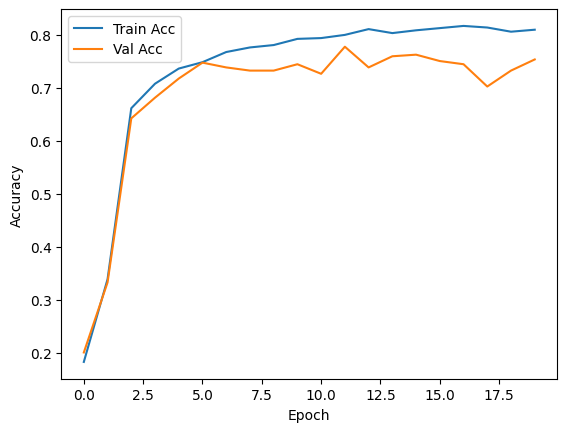

In [ ]:
train_acc_list,val_acc_list = train(gat)
evaluate(gat)
acc_plot(train_acc_list,val_acc_list)

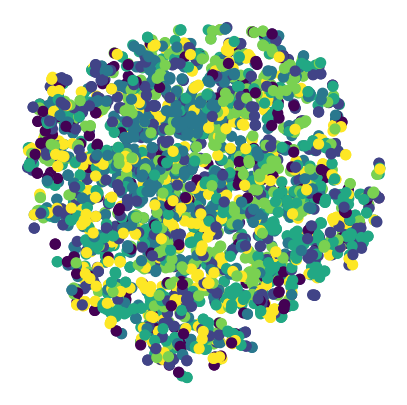

In [ ]:
untrained_gat = GAT(in_channels, hidden_channels, out_channels, 3, num_heads)

# Get embeddings
h, _ = untrained_gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

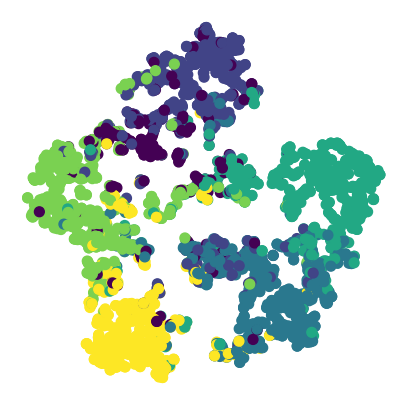

In [ ]:
h, _ = gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

**GIN**

In [ ]:
# define GIN Model
class GIN(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
      super().__init__()

      self.conv1 = GINConv(torch.nn.Sequential(torch.nn.Linear(in_channels, hidden_channels), \
                                                BatchNorm1d(hidden_channels),torch.nn.ReLU(), \
                                                torch.nn.Linear(hidden_channels, hidden_channels)))
      self.convs = torch.nn.ModuleList()
      for i in range(num_layers - 1):
          self.convs.append(GINConv(torch.nn.Sequential(torch.nn.Linear(hidden_channels, hidden_channels), \
                                                        BatchNorm1d(hidden_channels),torch.nn.ReLU(),\
                                                        torch.nn.Linear(hidden_channels, hidden_channels))))
      self.lin = torch.nn.Linear(hidden_channels, out_channels)

  def forward(self, x, edge_index):
      x = F.dropout(x, p=0.5, training=self.training)
      x = F.relu(self.conv1(x, edge_index))
      for conv in self.convs:
          x = F.dropout(x, p=0.5, training=self.training)
          x = F.relu(conv(x, edge_index))
      x = F.dropout(x, p=0.5, training=self.training)
      x = self.lin(x)
      return x,F.log_softmax(x, dim=1)

Epoch: 000, Loss: 1.7922, Val Loss: 1.6718, Train Acc: 0.1796, Val Acc: 0.2553
Epoch: 010, Loss: 1.3485, Val Loss: 1.3640, Train Acc: 0.4596, Val Acc: 0.4685
Epoch: 020, Loss: 0.9304, Val Loss: 1.1592, Train Acc: 0.6652, Val Acc: 0.6276
Epoch: 030, Loss: 0.7762, Val Loss: 1.1489, Train Acc: 0.7381, Val Acc: 0.6727
Epoch: 040, Loss: 0.6288, Val Loss: 0.9738, Train Acc: 0.8031, Val Acc: 0.7297
Epoch: 050, Loss: 0.5473, Val Loss: 0.9863, Train Acc: 0.8174, Val Acc: 0.7267
Epoch: 060, Loss: 0.4893, Val Loss: 1.2071, Train Acc: 0.8365, Val Acc: 0.7087
Epoch: 070, Loss: 0.4387, Val Loss: 1.1322, Train Acc: 0.8362, Val Acc: 0.7237
Epoch: 080, Loss: 0.3976, Val Loss: 1.1680, Train Acc: 0.8501, Val Acc: 0.7267
Epoch: 090, Loss: 0.3648, Val Loss: 1.2342, Train Acc: 0.8595, Val Acc: 0.7147
Epoch: 100, Loss: 0.3654, Val Loss: 1.2333, Train Acc: 0.8625, Val Acc: 0.6907
Epoch: 110, Loss: 0.3372, Val Loss: 1.3570, Train Acc: 0.8711, Val Acc: 0.6967
Epoch: 120, Loss: 0.3260, Val Loss: 1.2620, Train Ac

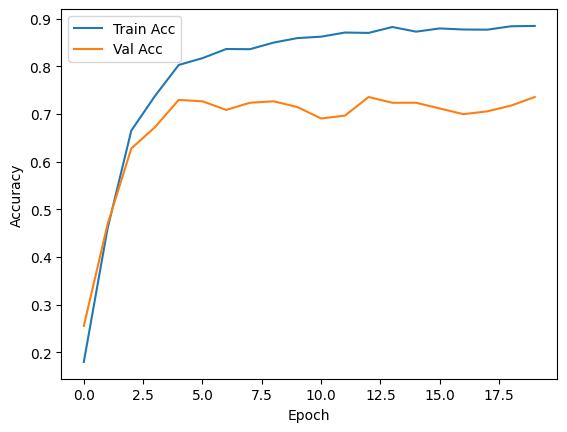

In [ ]:
#Define model parameters
in_channels = dataset.num_features
hidden_channels = 128
out_channels = dataset.num_classes
num_layers = 3

# Instantiate model and optimizer
gin = GIN(in_channels, hidden_channels, out_channels, num_layers).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(gin.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

train_acc_list,val_acc_list = train(gin)
evaluate(gin)
acc_plot(train_acc_list,val_acc_list)

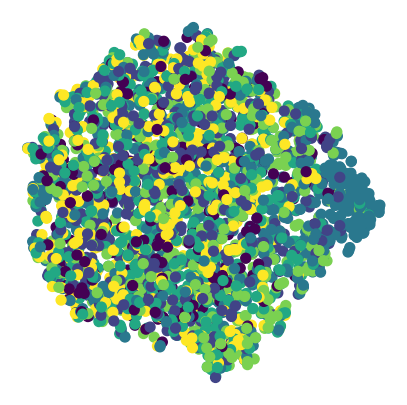

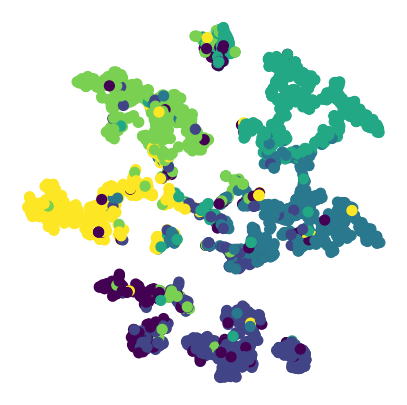

In [ ]:
# before training
untrained_gin = GIN(in_channels, hidden_channels, out_channels, num_layers)

# Get embeddings
h, _ = untrained_gin(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

# after training
h, _ = gin(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

# TUDataset--Graph Classification

In [ ]:
from torch_geometric.datasets import TUDataset

In [ ]:
dataset = TUDataset(root='.', name='PROTEINS').shuffle()

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Extracting ./PROTEINS/PROTEINS.zip
Processing...


Dataset: PROTEINS(1113)
-------------------
Number of graphs: 1113
Number of nodes: 48
Number of features: 3
Number of classes: 2


Done!


In [ ]:
# Create training, validation, and test sets
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Training set   = 890 graphs
Validation set = 111 graphs
Test set       = 112 graphs


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


**GAT**

In [ ]:
# Define GAT model

class GAT_protein(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, heads):
        super().__init__()

        self.heads = heads
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads))
        self.lin = torch.nn.Linear(hidden_channels * heads, out_channels)

    def forward(self, x, edge_index, batch):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        for conv in self.convs:
            x = F.elu(conv(x, edge_index))
            x = F.dropout(x, p=0.6, training=self.training)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=1)

gat_protein = GAT_protein(dataset.num_node_features, 32, dataset.num_classes, 3, 4)


In [ ]:
# train function for GAT
def train_protein_2(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=5e-4)
    epochs = 200

    model.train()
    for epoch in range(epochs+1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        # Train on batches
        for data in loader:
          optimizer.zero_grad()
          out = model(data.x, data.edge_index, data.batch)
          loss = criterion(out, data.y)
          total_loss += loss / len(loader)
          acc += accuracy_protein_2(out.argmax(dim=1), data.y) / len(loader)
          loss.backward()
          optimizer.step()

          # Validation
          val_loss, val_acc = test_protein_2(model, val_loader)

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} '
                  f'| Train Acc: {acc*100:>5.2f}% '
                  f'| Val Loss: {val_loss:.2f} '
                  f'| Val Acc: {val_acc*100:.2f}%')
          
    test_loss, test_acc = test_protein_2(model, test_loader)
    print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')
    
    return model

@torch.no_grad()
def test_protein_2(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y) / len(loader)
        acc += accuracy_protein_2(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy_protein_2(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

In [ ]:
gat_protein = train_protein_2(gat_protein, train_loader)

Epoch   0 | Train Loss: 0.68 | Train Acc: 61.36% | Val Loss: 0.70 | Val Acc: 56.57%
Epoch  10 | Train Loss: 0.61 | Train Acc: 67.86% | Val Loss: 0.54 | Val Acc: 72.39%
Epoch  20 | Train Loss: 0.61 | Train Acc: 69.10% | Val Loss: 0.56 | Val Acc: 73.11%
Epoch  30 | Train Loss: 0.61 | Train Acc: 68.24% | Val Loss: 0.62 | Val Acc: 66.57%
Epoch  40 | Train Loss: 0.59 | Train Acc: 69.69% | Val Loss: 0.56 | Val Acc: 75.02%
Epoch  50 | Train Loss: 0.60 | Train Acc: 69.66% | Val Loss: 0.56 | Val Acc: 71.39%
Epoch  60 | Train Loss: 0.60 | Train Acc: 70.33% | Val Loss: 0.56 | Val Acc: 73.67%
Epoch  70 | Train Loss: 0.59 | Train Acc: 70.60% | Val Loss: 0.55 | Val Acc: 73.39%
Epoch  80 | Train Loss: 0.59 | Train Acc: 70.36% | Val Loss: 0.57 | Val Acc: 73.39%
Epoch  90 | Train Loss: 0.58 | Train Acc: 71.07% | Val Loss: 0.55 | Val Acc: 76.01%
Epoch 100 | Train Loss: 0.59 | Train Acc: 70.72% | Val Loss: 0.55 | Val Acc: 76.65%
Epoch 110 | Train Loss: 0.59 | Train Acc: 70.64% | Val Loss: 0.54 | Val Acc:

**GIN**

In [ ]:
# Define GIN model for protein dataset
class GIN_protein(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN_protein, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                      BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return h, F.log_softmax(h, dim=1)

gin_protein = GIN_protein(dim_h=32)

In [ ]:
# train function for GIN
def train_protein(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=5e-4)
    epochs = 200

    model.train()
    for epoch in range(epochs+1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        # Train on batches
        for data in loader:
          optimizer.zero_grad()
          _, out = model(data.x, data.edge_index, data.batch)
          loss = criterion(out, data.y)
          total_loss += loss / len(loader)
          acc += accuracy_protein(out.argmax(dim=1), data.y) / len(loader)
          loss.backward()
          optimizer.step()

          # Validation
          val_loss, val_acc = test_protein(model, val_loader)

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} '
                  f'| Train Acc: {acc*100:>5.2f}% '
                  f'| Val Loss: {val_loss:.2f} '
                  f'| Val Acc: {val_acc*100:.2f}%')
          
    test_loss, test_acc = test_protein(model, test_loader)
    print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')
    
    return model

@torch.no_grad()
def test_protein(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        _, out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y) / len(loader)
        acc += accuracy_protein(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy_protein(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

In [ ]:
gin_protein = train_protein(gin_protein, train_loader)

Epoch   0 | Train Loss: 1.46 | Train Acc: 60.23% | Val Loss: 0.63 | Val Acc: 71.33%
Epoch  10 | Train Loss: 0.53 | Train Acc: 75.43% | Val Loss: 0.55 | Val Acc: 72.11%
Epoch  20 | Train Loss: 0.53 | Train Acc: 74.40% | Val Loss: 0.50 | Val Acc: 78.14%
Epoch  30 | Train Loss: 0.52 | Train Acc: 75.16% | Val Loss: 0.48 | Val Acc: 77.36%
Epoch  40 | Train Loss: 0.51 | Train Acc: 76.05% | Val Loss: 0.51 | Val Acc: 77.64%
Epoch  50 | Train Loss: 0.50 | Train Acc: 76.12% | Val Loss: 0.49 | Val Acc: 77.64%
Epoch  60 | Train Loss: 0.50 | Train Acc: 76.59% | Val Loss: 0.55 | Val Acc: 72.61%
Epoch  70 | Train Loss: 0.49 | Train Acc: 77.27% | Val Loss: 0.50 | Val Acc: 76.30%
Epoch  80 | Train Loss: 0.49 | Train Acc: 77.07% | Val Loss: 0.50 | Val Acc: 76.30%
Epoch  90 | Train Loss: 0.49 | Train Acc: 77.68% | Val Loss: 0.49 | Val Acc: 77.64%
Epoch 100 | Train Loss: 0.49 | Train Acc: 77.75% | Val Loss: 0.48 | Val Acc: 76.15%
Epoch 110 | Train Loss: 0.48 | Train Acc: 77.35% | Val Loss: 0.51 | Val Acc:

# FB15k_237--Link Prediction


In [ ]:
from torch_geometric.datasets import FB15k_237

In [ ]:
dataset = FB15k_237(root='data/fb15k237')

In [ ]:
data = dataset[0]
# len(dataset)

In [ ]:
data = train_test_split_edges(data)

/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [ ]:
data

Data(edge_type=[272115], num_nodes=14541, val_pos_edge_index=[2, 5520], test_pos_edge_index=[2, 11041], train_pos_edge_index=[2, 173044], train_neg_adj_mask=[14541, 14541], val_neg_edge_index=[2, 5520], test_neg_edge_index=[2, 11041])

In [ ]:
# Define the GAT model
class GAT_link(torch.nn.Module):
    def __init__(self, in_channels, out_channels, num_relations, heads):
        super(GAT_link, self).__init__()
        self.convs = torch.nn.ModuleList([
            GATConv(in_channels, out_channels, heads=heads)
            for _ in range(num_relations)
        ])
        
    def forward(self, x, edge_index):
        x = torch.cat([conv(x, edge_index) for conv in self.convs], dim=1)
        x = F.elu(x)
        return x



In [ ]:
# Define the GIN model
class GIN_link(torch.nn.Module):
    def __init__(self, in_channels, out_channels, num_layers, num_mlp_layers):
        super(GIN_link, self).__init__()
        self.convs = torch.nn.ModuleList([
            GINConv(torch.nn.Sequential(
                torch.nn.Linear(in_channels, out_channels),
                torch.nn.ReLU(),
                torch.nn.Linear(out_channels, out_channels),
                torch.nn.ReLU()
            ), train_eps=True)
            for _ in range(num_layers)
        ])
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(out_channels, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        )
        
    def forward(self, x, edge_index):
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
        x = self.mlp(x)
        return x

In [ ]:
# Define the training loop for the models
def train_link(model, optimizer, x, train_pos_edge_index, train_neg_edge_index):
    model.train()
    optimizer.zero_grad()
    pos_pred = model(x, train_pos_edge_index)
    neg_pred = model(x, train_neg_edge_index)
    pos_loss = -torch.log(torch.sigmoid(pos_pred)).mean()
    neg_loss = -torch.log(1 - torch.sigmoid(neg_pred)).mean()
    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Define the evaluation loop for the models
def test_link(model, x, pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        pos_pred = model(x, pos_edge_index)
        neg_pred = model(x, neg_edge_index)
        pos_pred = torch.sigmoid(pos_pred)
        neg_pred = torch.sigmoid(neg_pred)
        pos_acc = (pos_pred >= 0.5).sum().item() / pos_pred.size(0)
        neg_acc = (neg_pred < 0.5).sum().item() / neg_pred.size(0)
        acc = (pos_acc + neg_acc) / 2
    return acc

In [ ]:
# Set the device to use for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the GAT model
gat_link = GAT_link(in_channels=dataset.num_features, 
                out_channels=16, 
                num_relations=1345,
                heads=4).to(device)

# Initialize the optimizer and the number of epochs to train for
gat_optimizer = torch.optim.Adam(gat_link.parameters(), lr=0.005)
num_epochs = 200

# Train the GAT model
for epoch in range(num_epochs):
    loss = train_link(gat_link, gat_optimizer, data.x, 
                 data.train_pos_edge_index, data.train_neg_edge_index)
    train_acc = test_link(gat_link, data.x, 
                     data.train_pos_edge_index, data.train_neg_edge_index)
    val_acc = test_link(gat_link, data.x, 
                   data.val_pos_edge_index, data.val_neg_edge_index)
    print(f'Epoch: {epoch+1:02d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

AttributeError: ignored